In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# requires >= python 3.8
from typing import Dict, Literal

In [2]:
#!pip install pydot

## Create a custom feature extractor by extending `DictVectorizer`

In [3]:
# data type alias where value must be 0 or 1
Binary = Literal[0, 1]

class LinguisticFeatureEncoder(DictVectorizer):
    """
    Encodes linguistic features defined in self
    """
    def __init__(self, **kwargs):        
        super().__init__(sparse=kwargs.get("sparse", False))
        self.use_negative_features = kwargs.get("use_negative_features", False)
        # all positive features
        self.pos_features: Dict[str, Callable[str, Binary]] = {
            "ends_with_ed": lambda text: 1 if text.endswith("ed") else 0,
            "starts_with_vowel": lambda text: 1 if text[0] in "aeiou" else 0
        }
        
    @property
    def size(self) -> int:
        return len(self.get_feature_names())
    
    def create_feature_dict(self, datum) -> Dict[str, Binary]:
        """
        Creates a feature dictionary of str -> 1 or 0.
        Optionally include negated forms of each feature (i.e., NOT_*)
        """
        
        pos_features = dict((feat, fn(datum)) for (feat, fn) in self.pos_features.items())
        neg_features = dict()
        if not self.use_negative_features:
            return pos_features
        # assumes we're using positive features
        neg_features = dict((f"NOT_{feat}", 1 if value == 0 else value) for (feat, value) in pos_features.items())
        return {**pos_features, **neg_features}
            
    def fit(self, X, y = None):
        dicts = [self.create_feature_dict(datum = datum) for datum in X]
        super().fit(dicts)
        
    def transform(self, X, y = None):
        return super().transform([self.create_feature_dict(datum) for datum in X])

    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)
        

In [4]:
# Initialize our model and include negated features
lfe = LinguisticFeatureEncoder(use_negative_features=True)

In [5]:
lfe.fit(["test"])

In [6]:
# alternatively fit and then transform in a single step ...
lfe.fit_transform(["test", "eagle"])

array([[1., 1., 0., 0.],
       [1., 1., 0., 1.]])

In [7]:
lfe.get_feature_names()

['NOT_ends_with_ed',
 'NOT_starts_with_vowel',
 'ends_with_ed',
 'starts_with_vowel']

In [8]:
lfe.transform(["test"])

array([[1., 1., 0., 0.]])

In [9]:
lfe.transform(["ned"])

array([[1., 1., 1., 0.]])

In [10]:
lfe.transform(["test", "ned"])

array([[1., 1., 0., 0.],
       [1., 1., 1., 0.]])

In [11]:
lfe.size

4

## Build a network

Note that are engineered features have no sequential relationship, so **we do not use an RNN such as an LSTM for this architecture**.  Instead of simple feedforward network with fully connected layers, we could use a CNN for higher level feature extraction.

In [12]:
from tensorflow.keras.layers    import Input
from tensorflow.keras.layers    import Conv1D, MaxPooling1D, Flatten, concatenate, Dropout, Input, Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models    import Model, Sequential
from tensorflow.keras.utils     import plot_model

In [13]:
def make_model(max_features: int, embedding_dim: int, num_classes: int = 2):
    input_c2      = Input(shape=(max_features,))
    embeddings_c2 = Embedding(
        max_features, 
        embedding_dim,
        embeddings_initializer="uniform",
        embeddings_regularizer=None,
        activity_regularizer=None,
        embeddings_constraint=None,
        mask_zero=False,
        #weights=None,
        input_length=max_features,
        trainable=True
    )(input_c2)
    flat_c2       = Flatten()(embeddings_c2)
    hidden_c2_1   = Dense(20, activation="relu")(flat_c2)
    hidden_c2_2   = Dense(20, activation="relu")(hidden_c2_1)
    outputs       = Dense(1, activation="sigmoid")(hidden_c2_2)#"softmax")(hidden_c2_2)
    
    # model
    model         = Model(inputs=[input_c2], outputs=outputs)
    model.compile(
        loss="binary_crossentropy", #'categorical_crossentropy',
        optimizer="adam", 
        metrics=["accuracy"]
    )
    # summarize
    model.summary()
    return model

In [14]:
lfe = LinguisticFeatureEncoder(use_negative_features=True)

train_X  = lfe.fit_transform([
    "eagle",
    "scared",
    "timeless",
    "sacred",
    "allied"
])

train_y = np.array([
    1,
    0,
    0,
    1,
    1
])#.astype('float32').reshape((-1,1))

dev_X  = lfe.transform([
    "beagle",
    "rain",
    "fried",
    "elephant"
])

dev_y = np.array([
    1,
    0,
    1,
    0
])#.astype('float32').reshape((-1,1))

model = make_model(max_features=lfe.size, embedding_dim=3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 4, 3)              12        
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                260       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 713
Trainable params: 713
Non-trainable params: 0
_______________________________________________________________

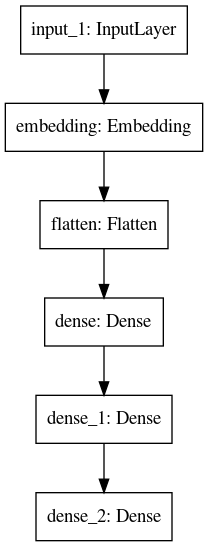

In [15]:
plot_model(model)

In [16]:
clf   = model.fit(
    [train_X], 
    train_y,
    validation_data=(
        [dev_X], 
        dev_y
    ),
    epochs=10, 
    batch_size=2, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

Epoch 1/10
3/3 [==============================] - 0s 112ms/step - loss: 0.6897 - accuracy: 0.7375 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6899 - accuracy: 0.6125 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5500 - val_loss: 0.6937 - val_accuracy: 0.5000
